# Analysis frequencies

In the previous section, we saw how to setup comparisons between an input signal $\blue{x[n]}$ and a collection of reference signals $\red{y_m}$ defined to be sinusoids (cosine waves) with analysis frequencies determined by the length $\blue{N}$ of the signal (and the sampling rate $f_s$).

In this section, we'll dig a little deeper, and see how this kind of comparison behaves for specific choices of $\blue{x}$.
This will both solidify our understanding of the process, and also illustrate some short-comings of the method that we'll need to improve.

In [1]:
%run ../setup.ipynb

## Comparing analysis frequencies

Let's see what happens when $\blue{x[n]}$ is also a sinusoid at one of our chosen analysis frequencies.

For this example, we'll take $f_s = 20$, $N = 40$ (2 seconds), and take $\blue{x}$ to be be the analysis frequency for $\red{m=3}$ ``[cycles / signal-duration]``.
Since the signal duration is 2 seconds, this corresponds to a frequency of $3/2$ ``[Hz]``.
Our sampled wave will be given by

```{math}
:label: xcosexample

\blue{x[n] = \cos\left(2\pi \cdot \frac{3}{40} \cdot n \right)}.
```

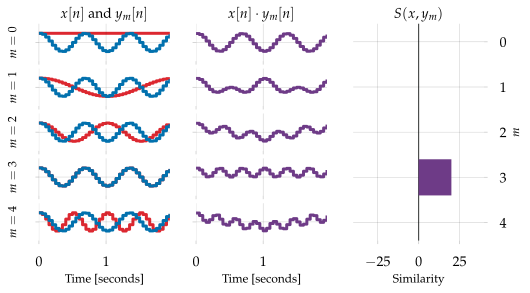

In [2]:
# Do the cosine transform
from matplotlib import gridspec

fig = plt.figure(figsize=figaspect(0.5))

M = 5

gs = gridspec.GridSpec(M, 3)

fs = 20
N = 40
t = np.arange(N) / fs
f0 = 1.5
x = np.cos(2 * np.pi * f0 * t)

xfft = np.fft.rfft(x).real

sharing = None
for i in range(M):
    ax1 = plt.subplot(gs[i, 0], sharex=sharing, sharey=sharing)
    
    ref = np.cos(2 * np.pi * i / N * fs * t)

    ax1.step(t, x, zorder=2, where='post')
    ax1.step(t, ref, zorder=-1,  where='post')
    ax1.set_ylim([-2.05, 2.05])
    ax1.set_yticks([0])
    ax1.set_yticklabels([])
    ax1.set_ylabel('$m={:d}$'.format(i))
    ax1.label_outer();

    xsim = x * ref
    
    ax2 = plt.subplot(gs[i, 1], sharex=sharing, sharey=sharing)
    ax2.step(t, xsim, color=colors[4], label=r'$x[n] \cdot y_m[n]$', where='post')
    ax2.set_yticks([0])
    ax2.set_ylim([-2.1, 2.1])
    ax2.label_outer();
    
    if i == 0:
        ax1.set_title('$x[n]$ and $y_m[n]$')
        ax2.set_title(r'$x[n] \cdot y_m[n]$')
    elif i == M - 1:
        ax1.set_xlabel('Time [seconds]')
        ax2.set_xlabel('Time [seconds]')
        
ax = plt.subplot(gs[:, 2])
ax.barh(np.arange(M), xfft[:M], color=colors[4])
ax.invert_yaxis();
ax.axvline(0, color=colors[3], zorder=-1, linewidth=1)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set(title=r'$S(x, y_m)$', ylabel=r'$m$', yticks=range(M), xlim=[-N, N], ylim=[M - 1 + .4, -0.4], xlabel='Similarity');
glue('analysis-example', fig, display=False)

```{glue:figure} analysis-example
---
name: analysis-example
---

Comparing a sinusoid $\blue{x[n]}$ at an analysis frequency to each reference signal $\red{y_m[n]}$.
```

{numref}`analysis-example` shows the similarity comparisons and resulting scores for the first five reference signals.
In this case, all scores are 0 except for $\red{m=3}$, which corresponds exactly to the frequency of our test signal $\blue{x[n]}$.

*Why does this happen?*

### Understanding analysis frequencies

Our definitions of *similarity* {eq}`similarity` and *reference signal* {eq}`reference-signal` lead to the following equation when $\blue{x[n]}$ is the cosine wave given above in {eq}`xcosexample`:

```{math}
:label: compare-analysis

\purple{S}(\blue{x}, \red{y_m}) &= \sum_{n=0}^{N-1} \blue{x[n]} \cdot \red{y_m[n]} \\
&= \sum_{n=0}^{N-1} \blue{\cos\left(2\pi \cdot \frac{3}{N} \cdot n \right)} \cdot \red{\cos\left(2\pi \cdot \frac{m}{N} \cdot n \right)}

```

We can simplify {eq}`compare-analysis` with a bit of trigonometry.
The **product-to-sum** rule for cosines gives us for any angles $\theta$ and $\phi$:

```{math}
\cos(\theta) \cdot \cos(\phi) = \frac{1}{2}\left(\cos(\theta + \phi) + \cos(\theta - \phi)\right)
```

If for each sample index $n$, we let 

$$\theta = 2\pi \cdot \frac{3}{N} \cdot n$$ 

be the angle of the first factor in the summation (the $x$ part), and let

$$\phi = 2\pi \cdot \frac{m}{N} \cdot n$$ 

be the angle of the second factor (the $y$ part), we would get

\begin{align*}
\theta + \phi &= 2\pi \cdot \frac{3 + m}{N} \cdot n\\
\theta - \phi &= 2\pi \cdot \frac{3 - m}{N} \cdot n,
\end{align*}


and each term of the summation in {eq}`compare-analysis` can be rewritten as:

\begin{align*}
\blue{\cos\left(2\pi \cdot \frac{3}{N} \cdot n \right)} \cdot \red{\cos\left(2\pi \cdot \frac{m}{N} \cdot n \right)}
&=\frac{1}{2} \cdot \left( \cos \left(2\pi \cdot \frac{3+ m}{N} \cdot n \right) + \cos\left(2\pi \cdot \frac{3-m}{N}\cdot n \right) \right)\\
&= \frac{1}{2} \left(  \red{y_{3+m}[n]} +  \red{y_{3-m}[n]} \right).
\end{align*}

This tells us that in this case, $\purple{S}$ can be computed by averaging the samples of reference signals $\red{y_{3+m}}$ and $\red{y_{3-m}}$.

```{margin}
More generally, if $\blue{x}$ was the $\red{k}$'th analysis frequency, we would have $\red{y_{k+m}}$ and $\red{y_{k-m}}$.
```

Plugging this back into Equation {eq}`compare-analysis`, we get

\begin{align*}
\purple{S}(\blue{x}, \red{y_m}) &= \sum_{n=0}^{N-1} \frac{1}{2} \left(  \red{y_{3+m}[n]} +  \red{y_{3-m}[n]} \right)\\
&= \frac{1}{2} \left(\sum_{n=0}^{N-1} \red{y_{3+m}[n]} \right) +
\frac{1}{2} \left(\sum_{n=0}^{N-1} \red{y_{3-m}[n]} \right)\\
\end{align*}

where the second step follows by breaking the summation into pieces only concerned with $\red{y_{3+m}}$ or $\red{y_{3-m}}$.

Now, let's consider two cases.  If $\red{m \neq 3}$, then both of these signals will have non-zero frequency.
Because they are both analysis frequencies, they will complete a whole number of cycles in the duration of the signal.
Though we haven't proven it yet, this means that the sample values will {ref}`sum to zero <sum-waves>`.
(We'll prove this fact and a slightly more powerful theorem a few sections from now.)

Since both summations will sum to zero, the full similarity score $\purple{S(x, y_m) = 0}$.

On the other hand, if $\red{m = 3}$, then our two signals will be $\red{y_{3+3}=y_{6}}$ and $\red{y_{3-3} = y_0}$.
The first signal $\red{y_6}$ will total to zero by the argument above.
The second signal, $\red{y_0}$ however will *not* total to zero, because $\red{y_0[n] = 1}$ for all $n$.
As a result, 

```{math}
\purple{S}(\blue{x}, \red{y_3}) = \frac{1}{2}\sum_{n=0}^{N-1} \red{y_0[n]} = \frac{1}{2} \cdot N.
```

There is a third case that can happen (but not in the example above), where $\blue{x}$ is generated by either the highest analysis frequency $\blue{k=N/2}$ (the Nyquist frequency) or if $\blue{k=0}$ (constant signal).
If this happens, and $\red{m=k}$, then

\begin{align*}
\red{y_{k+m}} = \red{y_{2\cdot N/2}} = \red{y_N} &= \red{y_0} & \text{if } \blue{k} = \red{m} = \frac{N}{2}\\
\red{y_{k+m}} = \red{y_{0+0}} &= \red{y_0} & \text{if } \blue{k} = \red{m} = 0.
\end{align*}

In either event, both terms in the summation become $N/2$ and the total score is $N$.

This explains the observation above: similarity between analysis frequencies is either $0$, $\frac{N}{2}$, or $N$, and the latter cases only occur when the reference signal $\red{y_m}$ has the same frequency as the input $\blue{x}$.


```{warning}

This cancellation **only** happens if $\blue{x}$ is a wave at an analysis frequency.

Waves at non-analysis frequencies will not generally share this property.
```

## Non-analysis frequencies

If instead of an analysis frequency, we had chosen $x$ to be a sinusoid at a frequency that **does not** complete a whole number of cycles over the signal duration, we could still try to apply the reasoning above, but it's not going to work out.

For example, if we take $m = 1.5$ ``[cycles / signal-duration]`` --- which is not an analysis frequency because 1.5 is not an integer --- we would have a wave $x[n]$ at $1.5/2 = 3/4$ ``[Hz]``:

```{math}

\blue{x[n]} = \cos\left(2\pi \cdot \frac{1.5}{40} \cdot n \right).
```


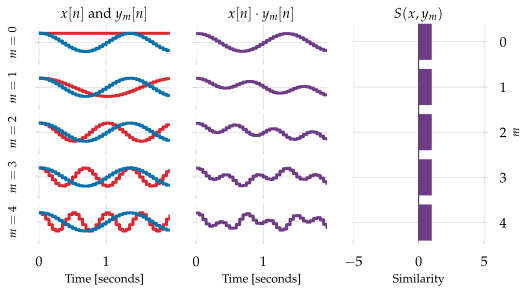

In [4]:
# Do the cosine transform
from matplotlib import gridspec

fig = plt.figure(figsize=figaspect(0.5))

M = 5

gs = gridspec.GridSpec(M, 3)

fs = 20
N = 40
t = np.arange(N) / fs
f0 = 0.75
x = np.cos(2 * np.pi * f0 * t)

xfft = np.fft.rfft(x).real

sharing = None
for i in range(M):
    ax1 = plt.subplot(gs[i, 0], sharex=sharing, sharey=sharing)
    
    ref = np.cos(2 * np.pi * i / N * fs * t)

    ax1.step(t, x, zorder=2,  where='post')
    ax1.step(t, ref, zorder=-1,  where='post')
    ax1.set_ylim([-2.05, 2.05])
    ax1.set_yticks([0])
    ax1.set_yticklabels([])
    ax1.set_ylabel('$m={:d}$'.format(i))
    ax1.label_outer();

    xsim = x * ref
    
    ax2 = plt.subplot(gs[i, 1], sharex=sharing, sharey=sharing)
    ax2.step(t, xsim, color=colors[4], label=r'$x[n] \cdot y_m[n]$', where='post')
    ax2.set_yticks([0])
    ax2.set_ylim([-2.1, 2.1])
    ax2.label_outer();
    
    if i == 0:
        ax1.set_title('$x[n]$ and $y_m[n]$')
        ax2.set_title(r'$x[n] \cdot y_m[n]$')
    elif i == M - 1:
        ax1.set_xlabel('Time [seconds]')
        ax2.set_xlabel('Time [seconds]')
        
ax = plt.subplot(gs[:, 2])
ax.barh(np.arange(M), xfft[:M], color=colors[4])
ax.invert_yaxis();
ax.axvline(0, color=colors[3], zorder=-1, linewidth=1)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set(title=r'$S(x, y_m)$', ylabel=r'$m$', yticks=range(M), xlim=[-5, 5], ylim=[M - 1 + .4, -0.4], xlabel='Similarity');
glue('non-analysis-example', fig, display=False)

```{glue:figure} non-analysis-example
---
name: non-analysis-example
---

Comparing a sinusoid $\blue{x[n]}$ at a non-analysis frequency to each reference signal $\red{y_m}$ results in non-zero similarities $\purple{S}$.
```

Like before, {numref}`non-analysis-example` shows the similarity comparisons and resulting scores for the first five reference signals.
In this case, the scores are all non-zero because the wave doesn't precisely line up with itself at $N$ samples.

This phenomenon is known as **spectral leakage**: a wave at a non-analysis frequency will *leak* across the entire frequency range, and appear to be a little similar to each analysis frequency.

We'll have more to say about this in subsequent chapters, but for now, it's important to understand that waves of different frequencies can still produce a non-zero similarity score.